In [4]:
# genral imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# deep learning
import cv2
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.utils import to_categorical



In [5]:
#pip -v install numpy==1.20.0

# PRE PROCESSING

In [6]:
DATA_PATH = '../input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules'
METADATA_PATH = os.path.join(DATA_PATH, 'module_metadata.json')

In [7]:
df = pd.read_json(METADATA_PATH, orient='index').sort_index()
df['image_filepath'] = df.image_filepath.apply(lambda x: os.path.join(DATA_PATH, x))
df

,image_filepath,anomaly_class
0,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
1,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
2,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
3,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
4,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
...,...,...
19995,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19996,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19997,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19998,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly



Unique values and their frequency:
anomaly_class
No-Anomaly        10000
Cell               1877
Vegetation         1639
Diode              1499
Cell-Multi         1288
Shadowing          1056
Cracking            940
Offline-Module      827
Hot-Spot            249
Hot-Spot-Multi      246
Soiling             204
Diode-Multi         175
Name: count, dtype: int64


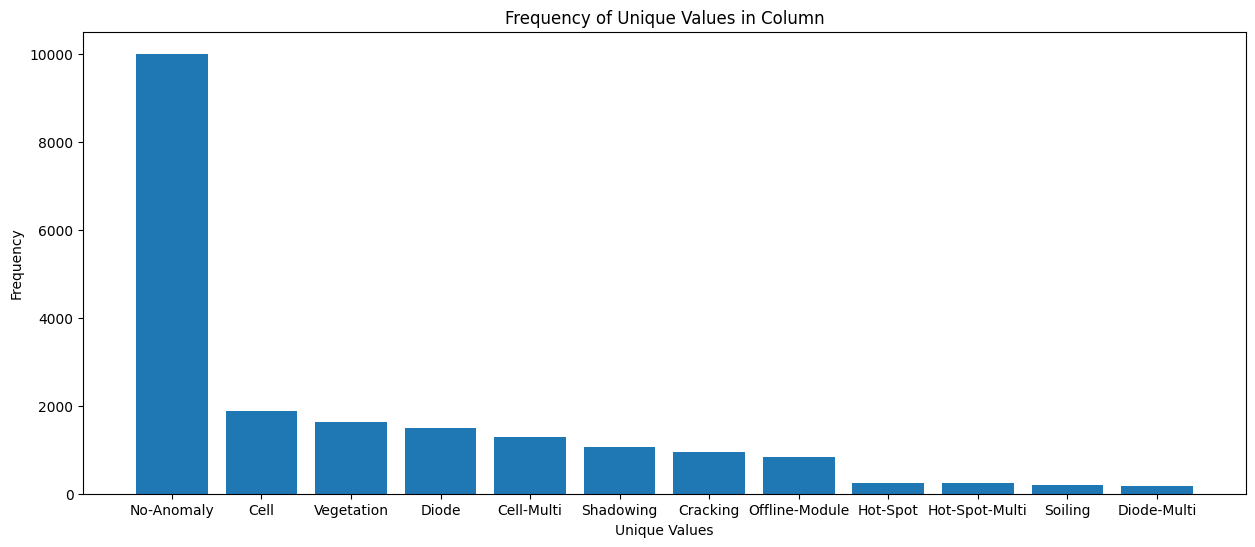

In [8]:
# Get unique values and their frequency
unique_values = df['anomaly_class'].value_counts()
print("\nUnique values and their frequency:")
print(unique_values)

# Set the figure size
plt.figure(figsize=(15, 6))

# Plot the bar chart
plt.bar(unique_values.index, unique_values.values)

# Set labels and title

plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Frequency of Unique Values in Column')

# Show the plot
plt.show()


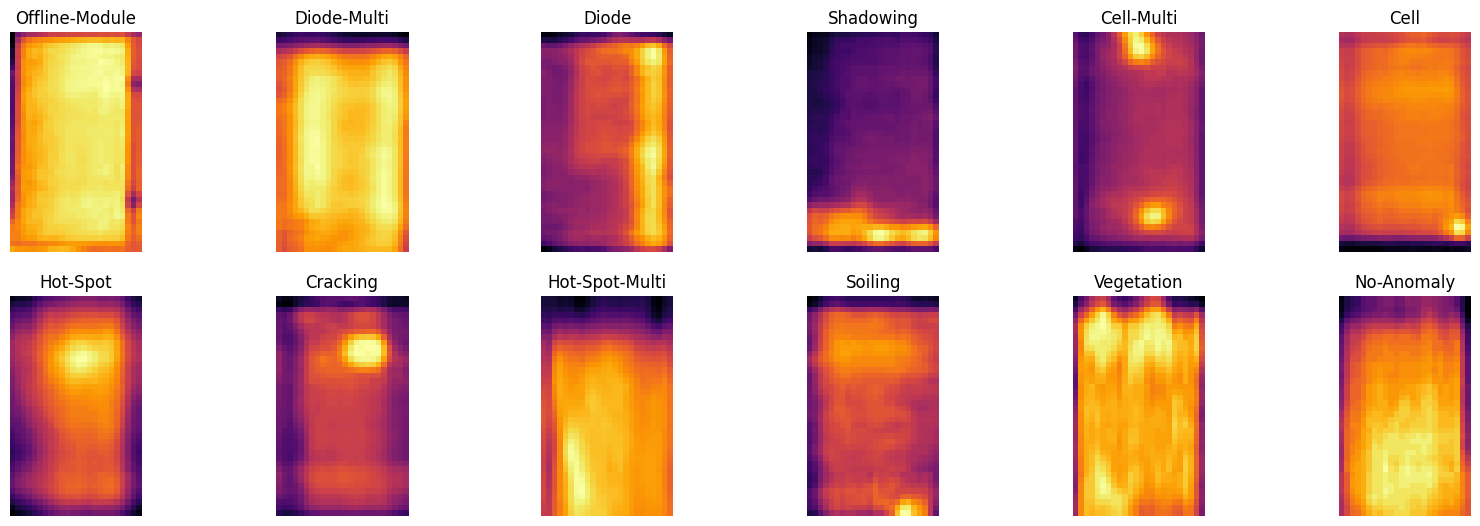

In [9]:
# Get unique anomaly classes
unique_classes = df['anomaly_class'].unique()

# Plot the sampled images
plt.figure(figsize=(20, 20))

for i, class_name in enumerate(unique_classes, start=1):
    # Sample one image for each class
    sample = df[df['anomaly_class'] == class_name].sample(n=1).iloc[0]
    
    image = cv2.imread(sample['image_filepath'], 0)
    
    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='inferno')
    plt.title(class_name)
    plt.axis('off')

plt.show()

## Splitting images based on module properties

As mentioned in readme of the dataset, the classes Hot-spot and Hot-spot Multi are anomalies from Thin film modules. These types of solar panels are less used in the industry when compared to (monocrystalline or polycrystalline) silicon modules and work completely different. But neither in Raptor maps github repository or in the dataset paper there is information about how many modules belong to the crystalline type and how much to the thin film type in the No-Anomaly class

In [10]:
crystal_df = df.query('anomaly_class != ("Hot-Spot", "Hot-Spot-Multi")')
crystal_df

,image_filepath,anomaly_class
0,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
1,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
2,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
3,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
4,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
...,...,...
19995,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19996,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19997,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19998,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly


In [11]:
im = cv2.imread(df['image_filepath'][0])
im = np.array(im)
im.shape

(40, 24, 3)

In [12]:
remaining_labels = ['No-Anomaly','Cell','Vegetation','Diode','Cell-Multi','Shadowing','Cracking','Offline-Module','Soiling','Diode-Multi']

In [13]:
train = []
labels = []
for label in remaining_labels:
    filtered_df = df[df['anomaly_class'] == label]
    



    for image_filepath in filtered_df['image_filepath']:
        try:
            # Read the image using OpenCV
            img = cv2.imread(image_filepath)

            # Convert the image to a numpy array
            img = np.array(img)

            # Append the resized image array to the list
            train.append(img)
            labels.append(label)


        except Exception as e:
            # Handle exceptions (e.g., if the image file is corrupted or cannot be read)
            print(f"Error processing image {image_filepath}: {str(e)}")

# Convert the list of arrays to a numpy array
train = np.array(train)
labels = np.array(labels)

In [14]:
train.shape

(19505, 40, 24, 3)

In [23]:
new_types = []

for i in range(labels.shape[0]):
    if labels[i] == "Cell":
        new_types.append(0)
    elif labels[i] == 'Cell-Multi':
        new_types.append(1)
    elif labels[i] == 'Cracking':
        new_types.append(2)
    elif labels[i] == 'Diode':
        new_types.append(3)
    elif labels[i] == 'Diode-Multi':
        new_types.append(4)
    elif labels[i] == 'No-Anomaly':
        new_types.append(5)
    elif labels[i] == 'Offline-Module':
        new_types.append(6)
    elif labels[i] == 'Shadowing':
        new_types.append(7)
    elif labels[i] == 'Soiling':
        new_types.append(8)
    elif labels[i] == 'Vegetation':
        new_types.append(9)
        
new_types = np.array(new_types)
new_types.shape

(19505,)

In [20]:
X_train, X_test, y_train, y_test = train_test_split( train, new_types, test_size=0.2, random_state=42)

In [21]:
np.unique(labels,return_counts=True)[0]

array(['Cell', 'Cell-Multi', 'Cracking', 'Diode', 'Diode-Multi',
       'No-Anomaly', 'Offline-Module', 'Shadowing', 'Soiling',
       'Vegetation'], dtype='<U14')

In [22]:
labels.shape

(19505,)

In [24]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Count the occurrences of each class in the original dataset
y = y_train
print("Class distribution before oversampling:", Counter(y))

X = X_train

# Reshape X if it's a 3D array (e.g., RGB images)
if len(X.shape) == 4:
    # If images are RGB, reshape to (num_samples, height * width * channels)
    X = X.reshape(X.shape[0], -1)

# Create a SMOTE oversampler
smote = SMOTE(random_state=42)

# Fit and apply the oversampler
X_resampled, y_resampled = smote.fit_resample(X, y)

# If you reshaped the input, reshape it back to its original shape
if len(X.shape) == 2:
    X_resampled = X_resampled.reshape(X_resampled.shape[0], 40, 24, 3)

# Count the occurrences of each class after oversampling
print("Class distribution after oversampling:", Counter(y_resampled))


Class distribution before oversampling: Counter({5: 7977, 0: 1521, 9: 1303, 3: 1202, 1: 1025, 7: 845, 2: 758, 6: 668, 8: 164, 4: 141})
Class distribution after oversampling: Counter({5: 7977, 0: 7977, 9: 7977, 3: 7977, 2: 7977, 7: 7977, 6: 7977, 8: 7977, 1: 7977, 4: 7977})


In [26]:
# Perform one-hot encoding using to_categorical
one_hot_labels_train = to_categorical(y_resampled, num_classes=10)

In [27]:
# Perform one-hot encoding using to_categorical
one_hot_labels_test = to_categorical(y_test, num_classes=10)

# TRAINING CUSTOM CNN MODEL

In [29]:
import tensorflow as tf

In [38]:
#original_dim = (40,24,3)
#target_size=(224,224)

model = Sequential()
#model.add(keras.layers.Input(original_dim))
#model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, target_size)))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (40,24,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (40,24,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 256 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10 , activation = 'softmax'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 40, 24, 32)        896       
                                                                 
 batch_normalization_6 (Bat  (None, 40, 24, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 20, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 20, 12, 32)        9248      
                                                                 
 batch_normalization_7 (Bat  (None, 20, 12, 32)        128       
 chNormalization)                                                
                                                      

In [40]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
              metrics=['accuracy'])

In [41]:
history = model.fit(X_resampled,one_hot_labels_train, batch_size = 32 ,epochs = 30 ,validation_data = (X_test,one_hot_labels_test))


Epoch 1/30
2493/2493 [==============================] - 29s 9ms/step - loss: 2.0506 - accuracy: 0.2622 - val_loss: 2.7167 - val_accuracy: 0.3092
Epoch 2/30
2493/2493 [==============================] - 23s 9ms/step - loss: 1.6824 - accuracy: 0.4151 - val_loss: 1.7315 - val_accuracy: 0.4304
Epoch 3/30
2493/2493 [==============================] - 23s 9ms/step - loss: 1.4240 - accuracy: 0.5064 - val_loss: 0.9765 - val_accuracy: 0.7080
Epoch 4/30
2493/2493 [==============================] - 23s 9ms/step - loss: 1.2131 - accuracy: 0.5822 - val_loss: 1.4165 - val_accuracy: 0.5445
Epoch 5/30
2493/2493 [==============================] - 23s 9ms/step - loss: 1.0679 - accuracy: 0.6309 - val_loss: 1.0387 - val_accuracy: 0.6606
Epoch 6/30
2493/2493 [==============================] - 23s 9ms/step - loss: 0.9497 - accuracy: 0.6732 - val_loss: 0.8374 - val_accuracy: 0.7255
Epoch 7/30
2493/2493 [==============================] - 23s 9ms/step - loss: 0.8787 - accuracy: 0.6970 - val_loss: 0.8497 - val_ac

In [43]:
history2 = model.fit(X_resampled,one_hot_labels_train, batch_size = 32 ,epochs = 3 ,validation_data = (X_test,one_hot_labels_test))


Epoch 1/3
2493/2493 [==============================] - 23s 9ms/step - loss: 0.1735 - accuracy: 0.9465 - val_loss: 1.5809 - val_accuracy: 0.6345
Epoch 2/3
2493/2493 [==============================] - 22s 9ms/step - loss: 0.1620 - accuracy: 0.9492 - val_loss: 1.1396 - val_accuracy: 0.7570
Epoch 3/3
2493/2493 [==============================] - 22s 9ms/step - loss: 0.1562 - accuracy: 0.9529 - val_loss: 1.2708 - val_accuracy: 0.7290


In [44]:
history3 = model.fit(X_resampled,one_hot_labels_train, batch_size = 32 ,epochs = 3 ,validation_data = (X_test,one_hot_labels_test))


Epoch 1/3
2493/2493 [==============================] - 22s 9ms/step - loss: 0.1546 - accuracy: 0.9529 - val_loss: 1.1026 - val_accuracy: 0.7801
Epoch 2/3
2493/2493 [==============================] - 23s 9ms/step - loss: 0.1454 - accuracy: 0.9558 - val_loss: 1.2802 - val_accuracy: 0.7503
Epoch 3/3
2493/2493 [==============================] - 22s 9ms/step - loss: 0.1437 - accuracy: 0.9553 - val_loss: 1.3985 - val_accuracy: 0.7462


In [45]:
history4 = model.fit(X_resampled,one_hot_labels_train, batch_size = 32 ,epochs = 2 ,validation_data = (X_test,one_hot_labels_test))


Epoch 1/2
2493/2493 [==============================] - 23s 9ms/step - loss: 0.1460 - accuracy: 0.9567 - val_loss: 1.1934 - val_accuracy: 0.7662
Epoch 2/2
2493/2493 [==============================] - 23s 9ms/step - loss: 0.1336 - accuracy: 0.9600 - val_loss: 1.4556 - val_accuracy: 0.6929


In [46]:
history4 = model.fit(X_resampled,one_hot_labels_train, batch_size = 32 ,epochs = 2 ,validation_data = (X_test,one_hot_labels_test))


Epoch 1/2
2493/2493 [==============================] - 23s 9ms/step - loss: 0.1326 - accuracy: 0.9594 - val_loss: 1.6077 - val_accuracy: 0.7239
Epoch 2/2
2493/2493 [==============================] - 23s 9ms/step - loss: 0.1250 - accuracy: 0.9621 - val_loss: 1.3018 - val_accuracy: 0.7708


In [ ]:
#from tensorflow.keras.models import load_model

# Replace 'your_model.h5' with the actual path to your model file
#model = load_model('/kaggle/working/proper.h5')

# VALIDATION AND TESTING

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
results = model.evaluate(X_test,one_hot_labels_test, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

[1.301832914352417, 0.7708280086517334]
Test Accuracy: 77.08%


In [52]:
model.save("major.h5")

In [ ]:
y_test

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis =1)
from tensorflow.keras.utils import to_categorical

# Convert predicted class labels to one-hot encoding using to_categorical
y_pred_cat = to_categorical(y_pred)

# Calculate classification report
class_report = classification_report(one_hot_labels_test, y_pred_cat)
print("\nClassification Report:")
print(class_report)




122/122 [==============================] - 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       356
           1       0.39      0.44      0.41       263
           2       0.59      0.61      0.60       182
           3       0.87      0.96      0.91       297
           4       0.88      0.88      0.88        34
           5       0.91      0.93      0.92      2023
           6       0.56      0.67      0.61       159
           7       0.66      0.65      0.66       211
           8       0.25      0.38      0.30        40
           9       0.68      0.43      0.52       336

   micro avg       0.77      0.77      0.77      3901
   macro avg       0.64      0.65      0.64      3901
weighted avg       0.77      0.77      0.77      3901
 samples avg       0.77      0.77      0.77      3901



Confusion Matrix:
[[ 183   60   16    4    0   38    7    8    6   34]
 [  40  115   37    6    1   14    5   11   12   22]
 [   3   42  111    0    0    2    7    7    9    1]
 [   0    0    0  284    0   10    2    1    0    0]
 [   0    0    0    1   30    2    1    0    0    0]
 [   8   10    3   29    1 1881   50   29    7    5]
 [   3    1    1    1    1   42  106    3    1    0]
 [   5   19    2    1    1   35    5  138    1    4]
 [   5    9    6    0    0    1    0    1   15    3]
 [  64   42   13    2    0   42    7   12   10  144]]


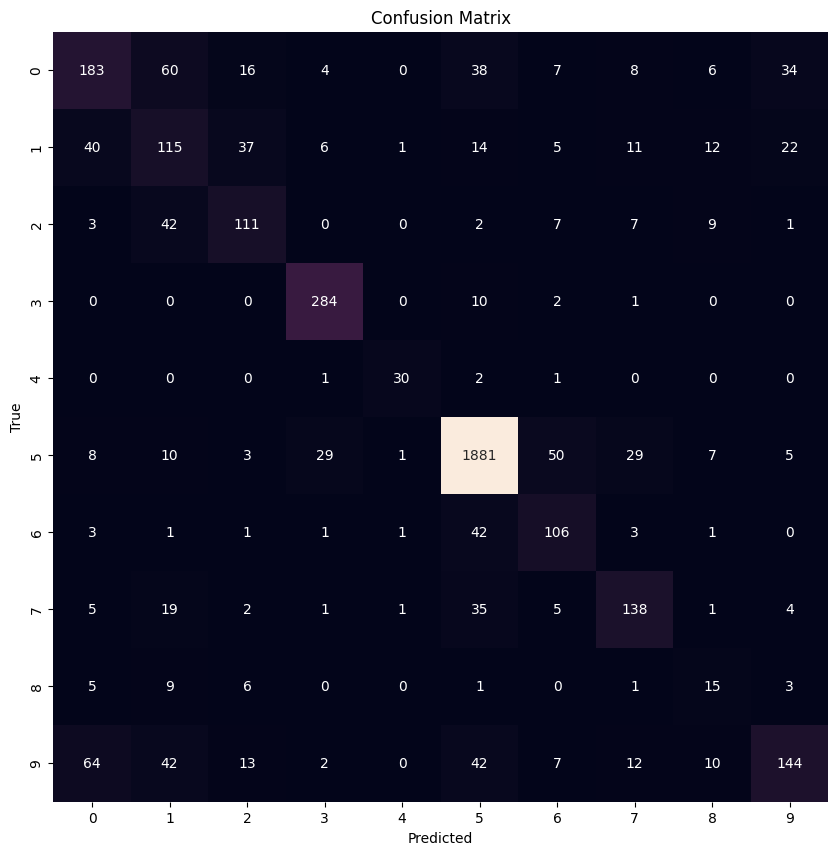

In [49]:
y_test_solo = np.argmax(one_hot_labels_test,axis = 1)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_solo, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


# Plot the confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cbar=False,
            xticklabels=np.unique(y_test_solo), yticklabels=np.unique(y_test_solo))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


ROC-AUC for Class 0: 0.74
ROC-AUC for Class 1: 0.69
ROC-AUC for Class 2: 0.79
ROC-AUC for Class 3: 0.97
ROC-AUC for Class 4: 0.94
ROC-AUC for Class 5: 0.92
ROC-AUC for Class 6: 0.82
ROC-AUC for Class 7: 0.82
ROC-AUC for Class 8: 0.68
ROC-AUC for Class 9: 0.70
Micro-average ROC-AUC: 0.87


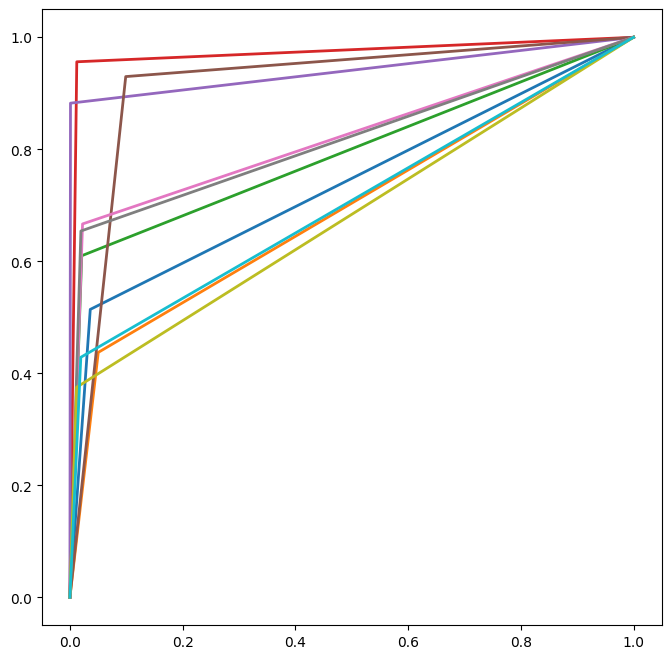

In [50]:
from sklearn.metrics import roc_auc_score, roc_curve


y_true =one_hot_labels_test
y_scores = y_pred_cat

# Compute ROC curve and ROC-AUC score for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_scores[:, i])

# Compute micro-average ROC curve and ROC-AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_scores.ravel())
roc_auc["micro"] = roc_auc_score(y_true, y_scores, multi_class="ovr", average="micro")

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    
# Print ROC-AUC score for each class
for i in range(n_classes):
    print(f"ROC-AUC for Class {i}: {roc_auc[i]:.2f}")

# Print micro-average ROC-AUC score
print(f"Micro-average ROC-AUC: {roc_auc['micro']:.2f}")

    
